In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
sys.path.append('../modules')

import utils
from RateEchoStateNet import RateEchoStateNet as RateNet

import numpy as np
from numba import njit, prange
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate

# Generate data from Lorenz attractor

In [3]:
xyz0 = np.random.rand(3)
sigma = 10
rho = 28
beta = 8/3

start = 0
end = 300
Time = np.linspace(start, end, int(1e5))

solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = xyz0, args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True)
solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = solver.sol(end), args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True, method = 'DOP853')
xyz = solver.sol(Time).T

xyz -= xyz.min(axis = 0)
xyz /= xyz.max(axis = 0)

xyz = np.ascontiguousarray(xyz[::2])
Time = Time[::2]

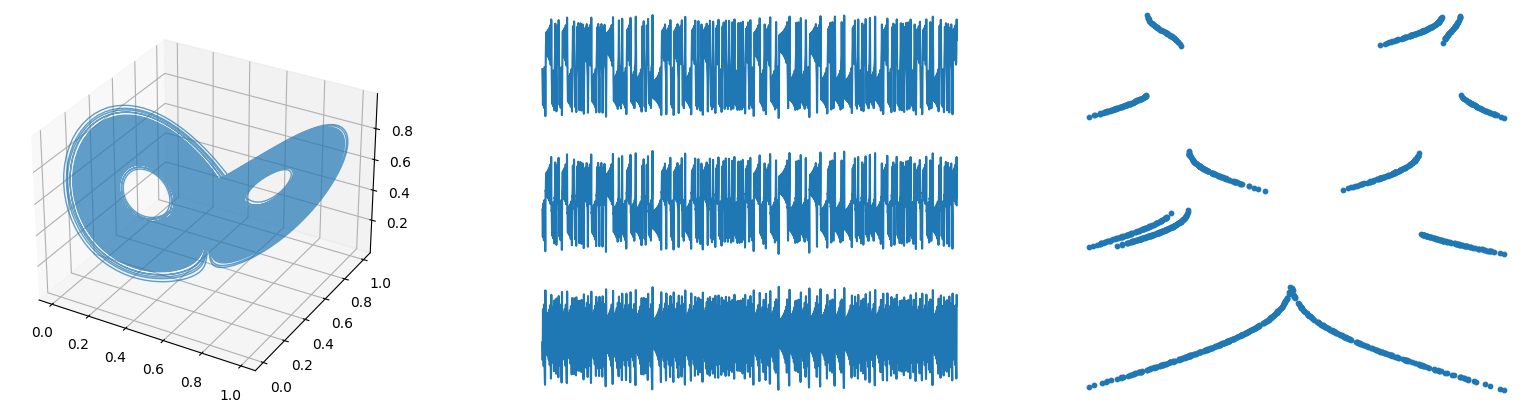

In [4]:
fig = plt.figure(figsize = (20,5))
axs = fig.subplot_mosaic('A03;A14;A25')
ss = axs['A'].get_subplotspec()
axs['A'].remove()
axs['A'] = fig.add_subplot(ss, projection='3d')
axs['A'].plot(*xyz.T, alpha=0.7, linewidth=1)

for i in range(3):
    axs[str(i)].plot(Time, xyz[:,i])
    axs[str(i)].axis('off')
    axs[str(i + 3)].scatter(*utils.return_map(xyz[:,i]), s = 10)
    axs[str(i + 3)].axis('off')
plt.show()

# Echo State Network

## Training example

In [5]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NIpunts = 3

dt = 0.05

tau_E = 1.
tau_I = 1.

net = RateNet(NE, NI, NIpunts, dt, tau_E, tau_I, burnSteps = None,
              input_sparse = 0.3, max_bias = None,
              method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

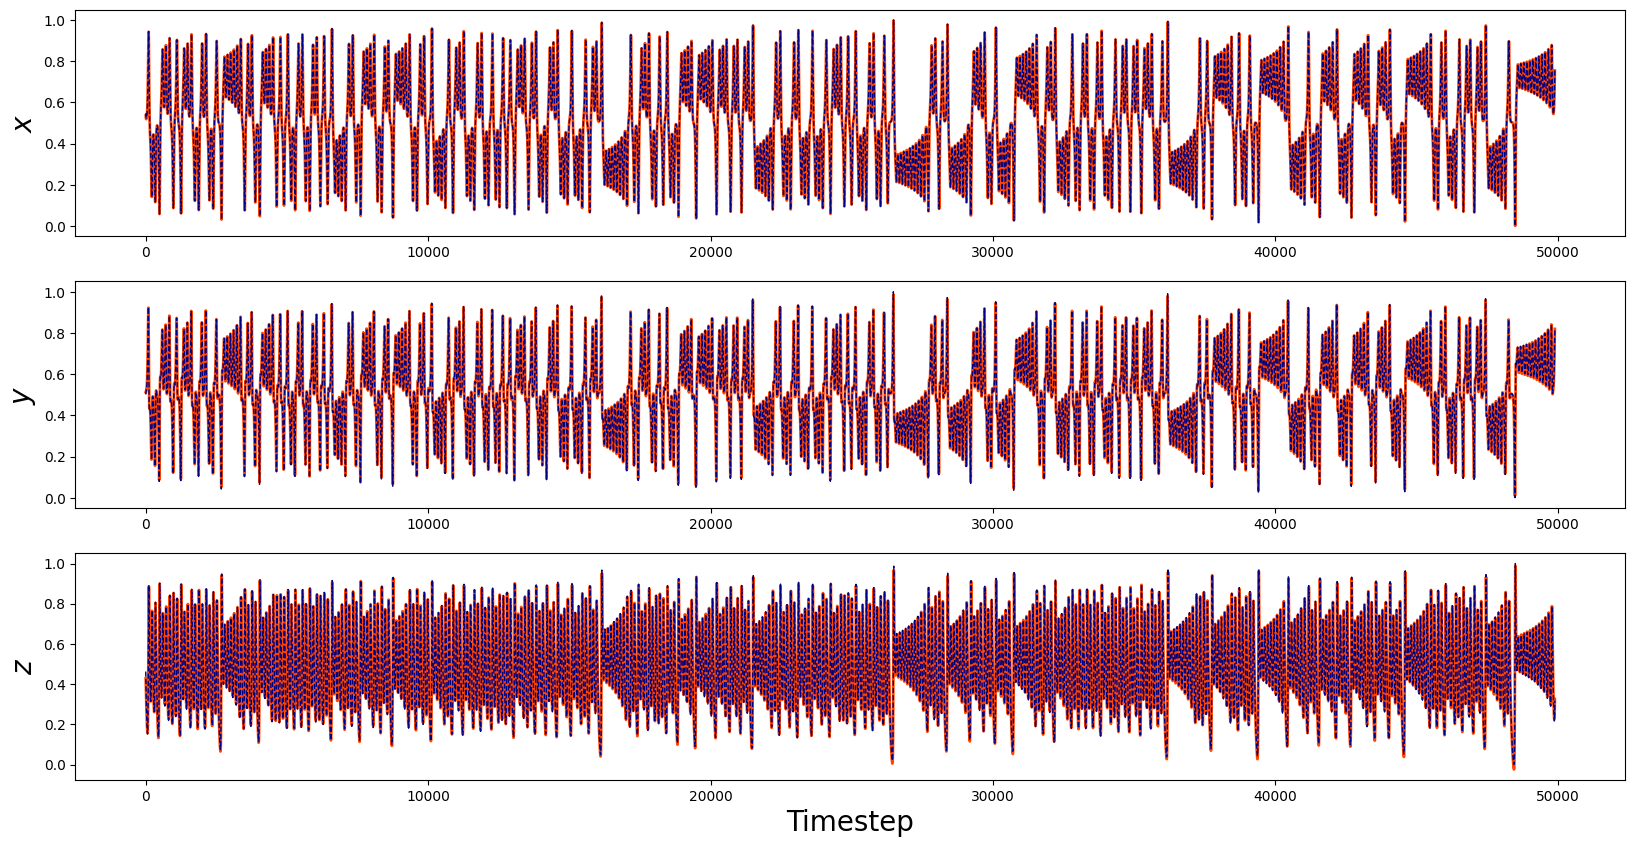

In [6]:
initTraining = 100
MSE, trained_output = net.train_model(xyz, initTraining, plot = True, alpha = 1e-3)

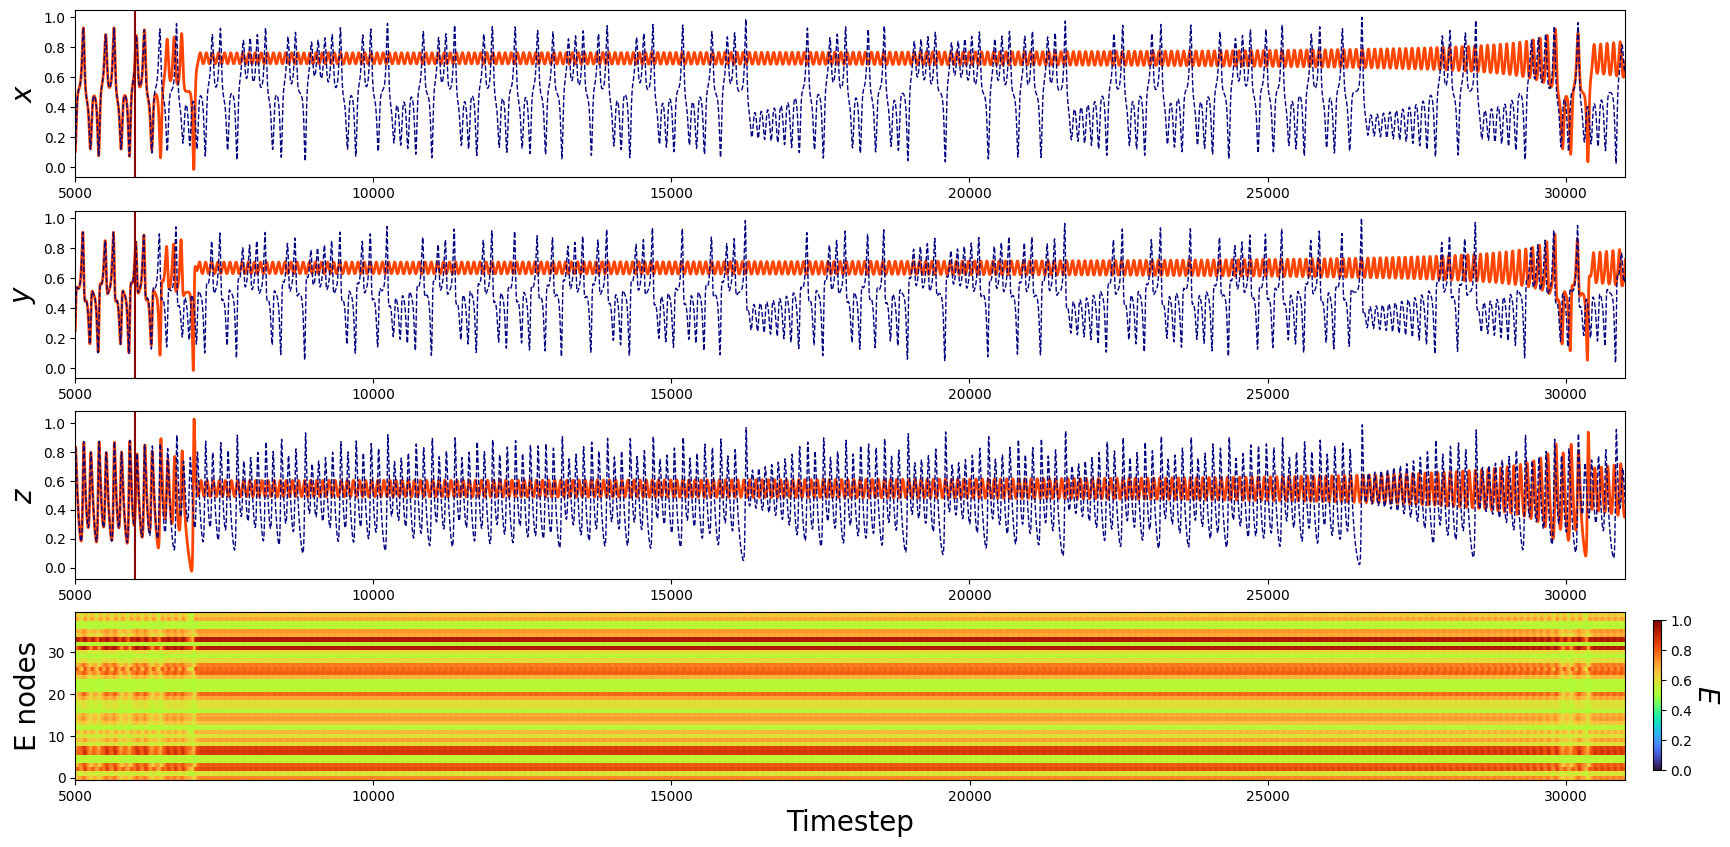

In [7]:
idx_start = 5000
idx_echo = 1000
nLoops = 25000
E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start, idx_echo = idx_echo,
                                             plot = True)

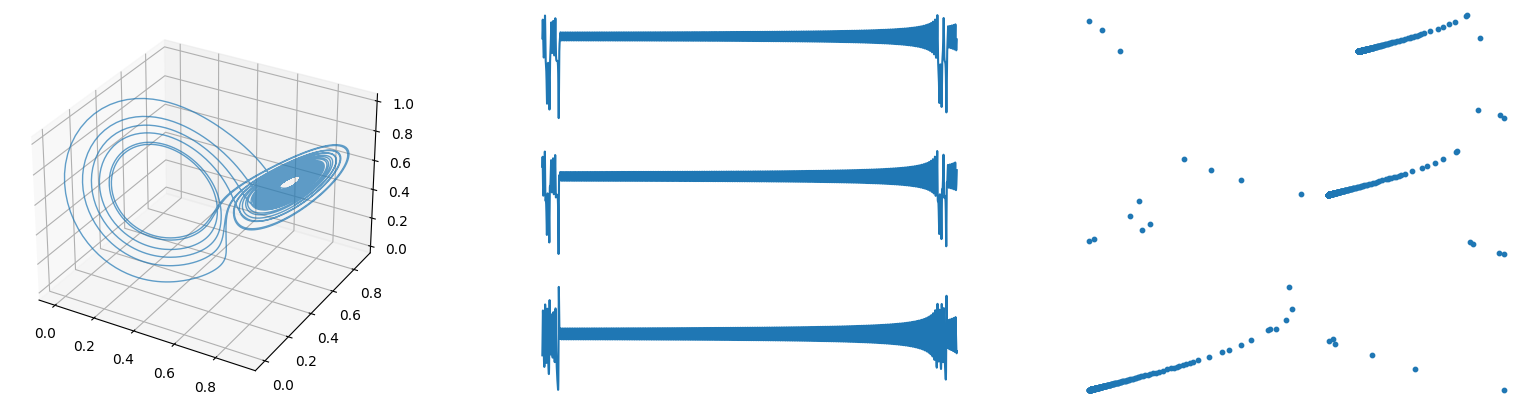

In [8]:
net.plot_attractor(output_echo[idx_echo:])

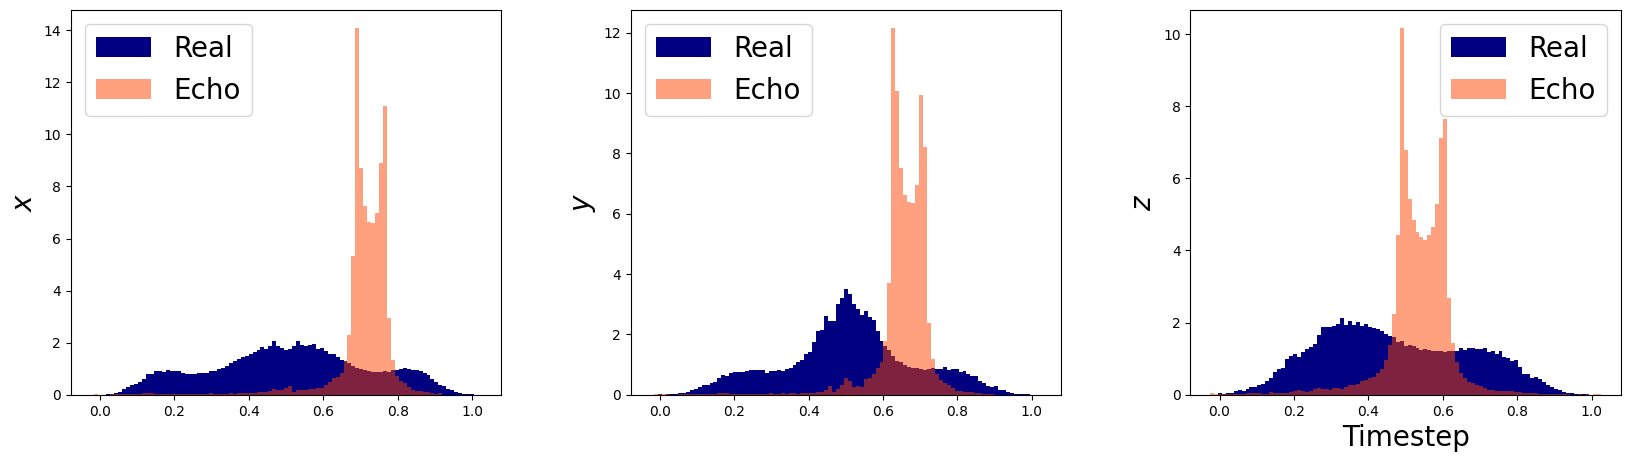

In [9]:
_ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)

## Fit best Ridge regression parameter

In [5]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NIpunts = 3

dt = 0.05

tau_E = 1.
tau_I = 1.

net = RateNet(NE, NI, NIpunts, dt, tau_E, tau_I, burnSteps = None,
              input_sparse = 0.3, max_bias = None,
              method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

In [7]:
initTraining = 100

In [8]:
idx_start = 5000
idx_echo = 1000
nLoops = 25000

net.fit_alpha(xyz, initTraining, idx_start, idx_echo, nLoops,
              alpha_min = 1e-8, alpha_max = 1e-1, NAlpha = 30)

New MSE: 1.23842 for alpha = 1e-08


In [9]:
net.alpha, net.MSE_echo

(1e-08, 1.2384168450257158)

In [10]:
E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start,
                                             idx_echo = idx_echo, plot = True)

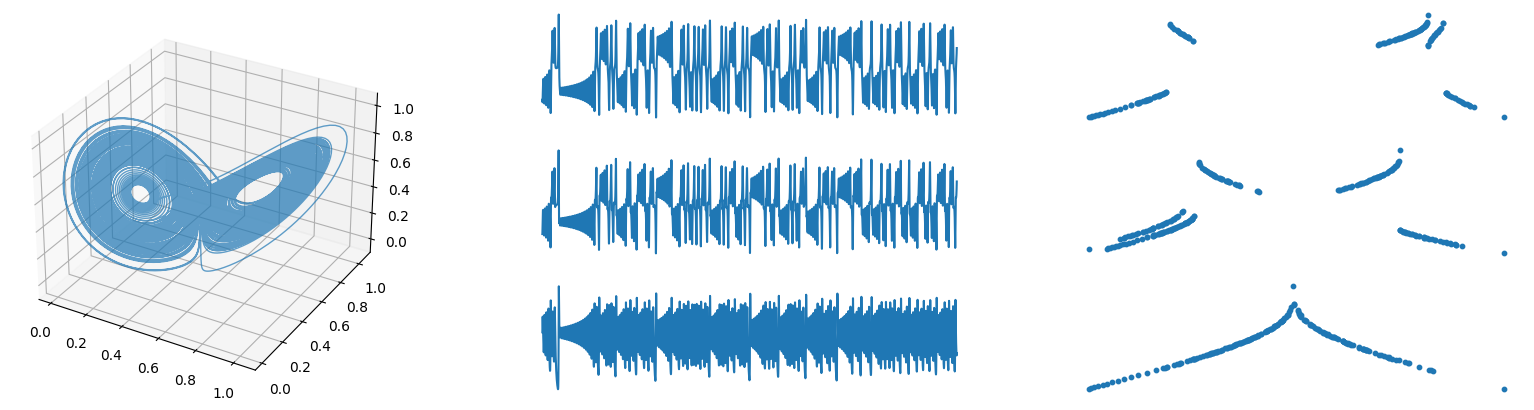

In [11]:
net.plot_attractor(output_echo[idx_echo:])

In [12]:
_ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)

# Plasticity

In [66]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NIpunts = 3

dt = 0.05

tau_E = 1.
tau_I = 1.

net_Plas = RateNet(NE, NI, NIpunts, dt, tau_E, tau_I, burnSteps = None,
                   input_sparse = 0.3, max_bias = None,
                   method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

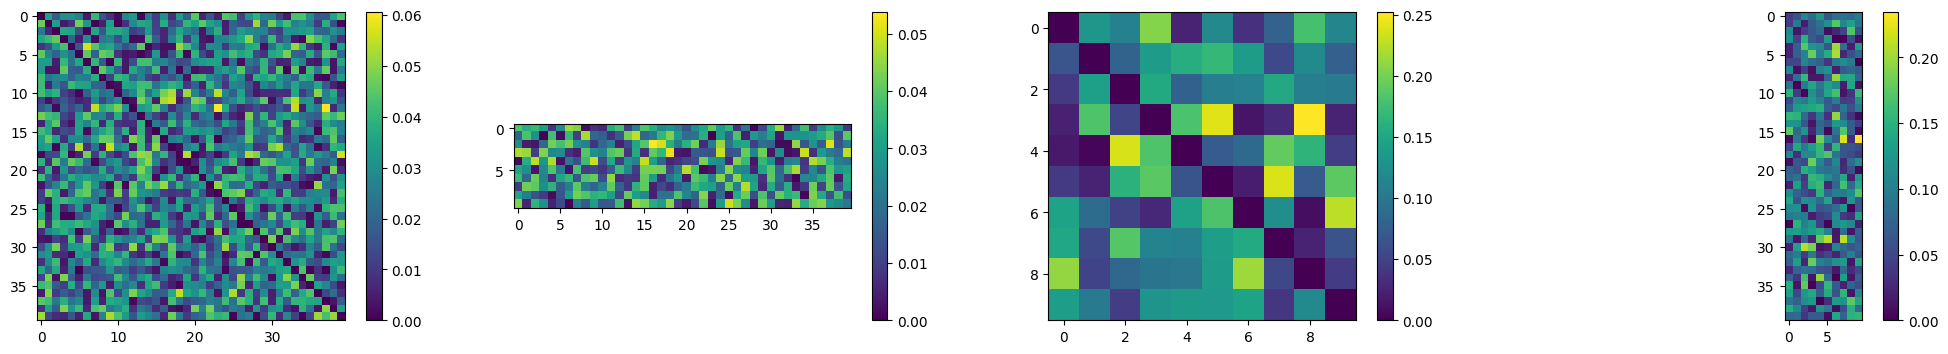

In [67]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (25,4))
for ax, mat in zip(axs, [net_Plas.WEE, net_Plas.WIE, net_Plas.WII, net_Plas.WEI]):
    im = ax.imshow(mat, interpolation = 'None', vmin = 0)
    plt.colorbar(im, ax = ax)
plt.show()

In [68]:
eta_EE = 1e-2
eta_II = 1e-2
eta_EI = 1e-2
eta_IE = 1e-2

rho_E = 0.5
rho_I = 1

net_Plas._set_plasticity(eta_EE, eta_EI, eta_IE, eta_II, rho_E, rho_I)

net_Plas.run_plasticity(xyz)

In [69]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (25,4))
for ax, mat in zip(axs, [net_Plas.WEE, net_Plas.WIE, net_Plas.WII, net_Plas.WEI]):
    im = ax.imshow(mat, interpolation = 'None', vmin = 0)
    plt.colorbar(im, ax = ax)
plt.show()

In [75]:
initTraining = 100

idx_start = 5000
idx_echo = 1000
nLoops = 45000

net_Plas.fit_alpha(xyz, initTraining, idx_start, idx_echo, nLoops,
                   alpha_min = 1e-8, alpha_max = 1e-1, NAlpha = 30)

New MSE: 1.59487 for alpha = 1e-08
New MSE: 1.23437 for alpha = 0.0034482855172413797
New MSE: 1.20357 for alpha = 0.02068966310344828
New MSE: 1.19339 for alpha = 0.02413793862068966
New MSE: 1.15079 for alpha = 0.02758621413793104
New MSE: 1.07112 for alpha = 0.031034489655172418
New MSE: 0.95857 for alpha = 0.03793104068965518


In [76]:
net_Plas.alpha, net_Plas.MSE_echo

(0.03793104068965518, 0.9585688980755451)

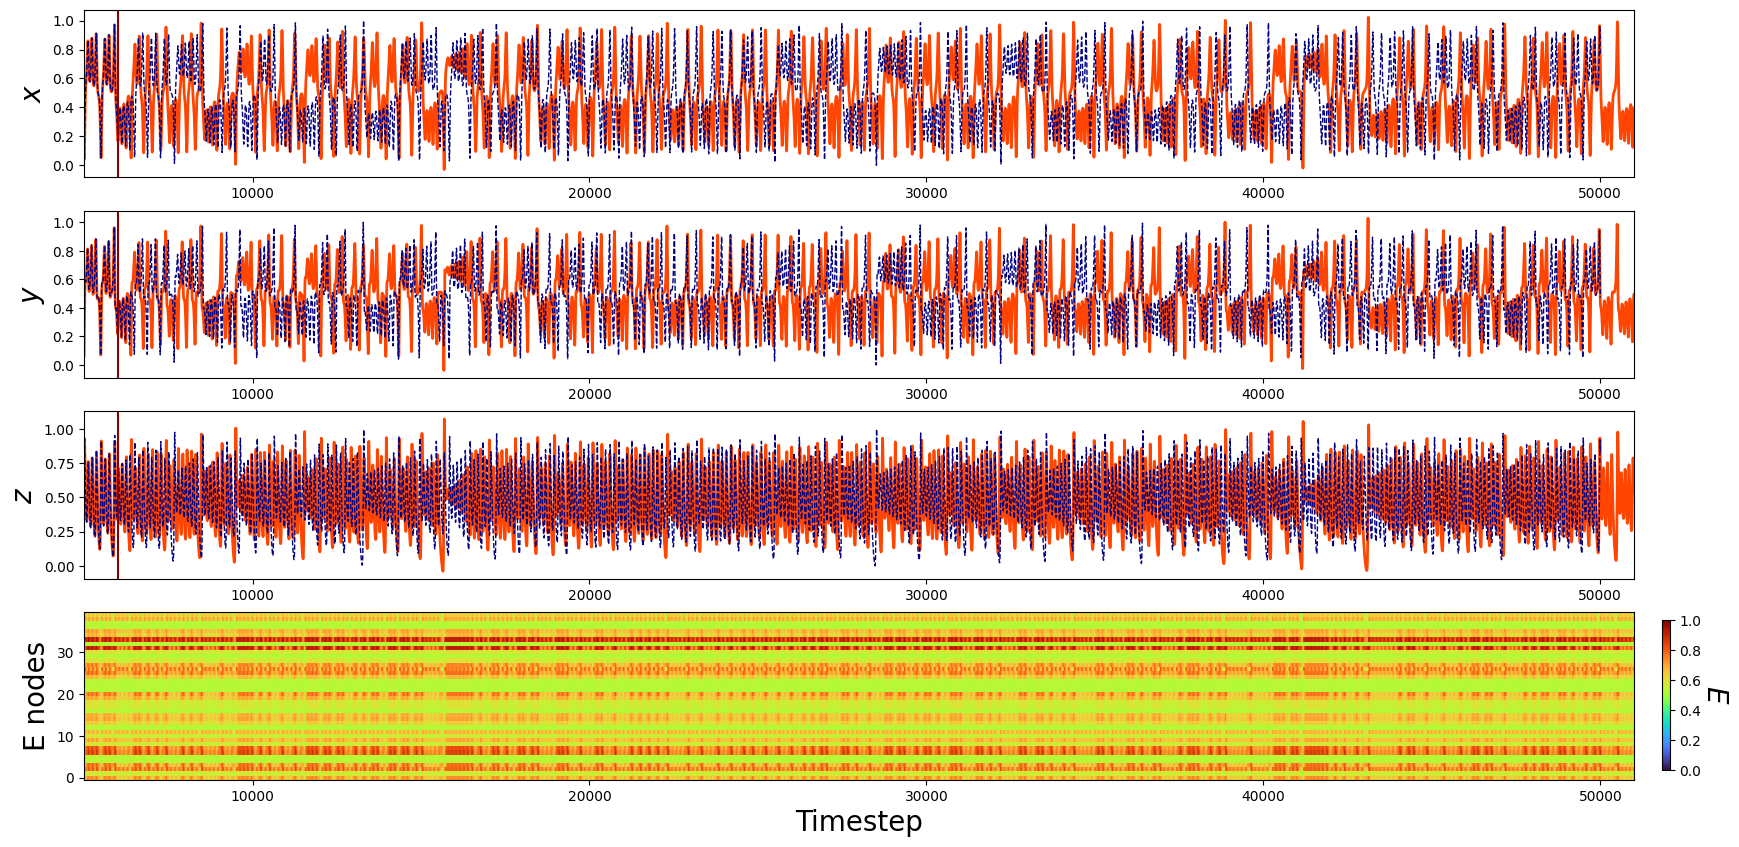

In [77]:
E_echo, I_echo, output_echo = net_Plas.echo_state(xyz, nLoops, idx_start = idx_start,
                                                  idx_echo = idx_echo, plot = True)

In [78]:
net_Plas.plot_attractor(output_echo[idx_echo:])

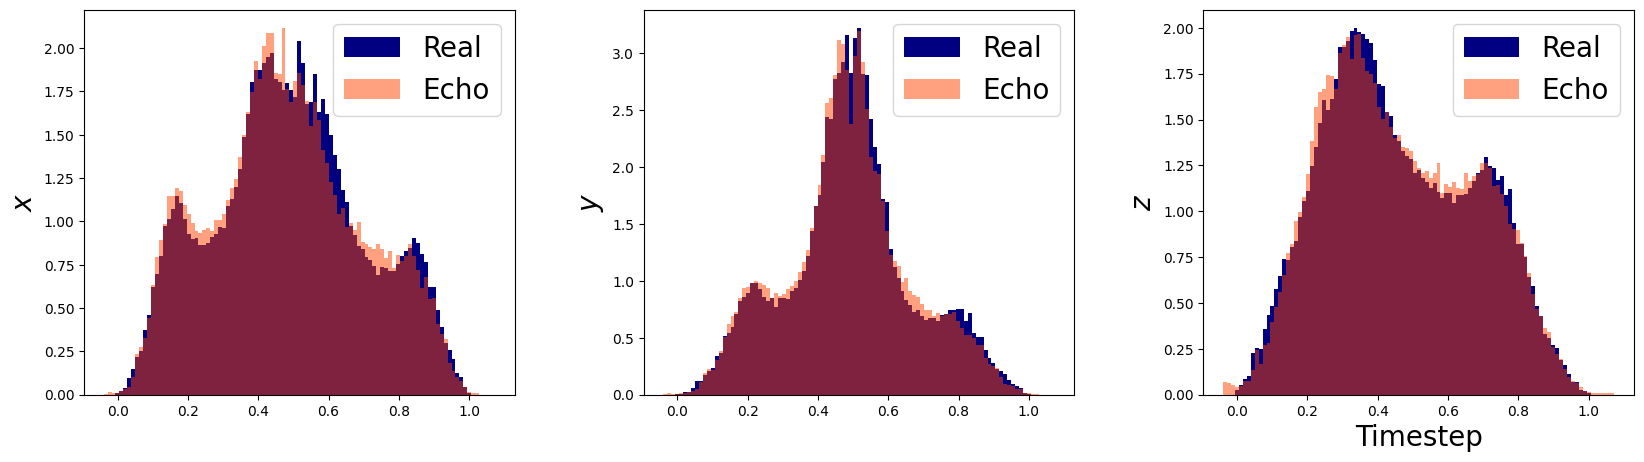

In [79]:
_ = net_Plas.compare_results(xyz, output_echo[idx_echo:], NBins = 100)